In [32]:
## LOAD MODEL
from langchain_ollama import ChatOllama
llm = ChatOllama(model="llama3.2:latest", temperature=0)

## TEST MESSAGING
from langchain_core.messages import HumanMessage
llm.invoke([HumanMessage(content="Hi! I'm Bob")])


AIMessage(content="Hello Bob! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-03-18T08:59:22.4405294Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2766438200, 'load_duration': 30839100, 'prompt_eval_count': 30, 'prompt_eval_duration': 84000000, 'eval_count': 27, 'eval_duration': 2649000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-cf2d5354-84ad-4ff1-8faa-2e2307a1ca65-0', usage_metadata={'input_tokens': 30, 'output_tokens': 27, 'total_tokens': 57})

In [33]:
## SYSTEM PROMPT
#
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
#
# prompt_template = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a travel planner. Ask user about travel preferences and use this information to propose a travel plan.",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )

In [34]:
## MESSAGE TRIMMING - how much past messages are remembered

from langchain_core.messages import AIMessage, SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=llm,
    include_system=True,
    allow_partial=False,
    start_on="human",
)


In [48]:
## PERSISTENCE
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END,  MessagesState, StateGraph

from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

from typing_extensions import Literal
# Schema for structured output
from pydantic import BaseModel, Field

# DEFINE CLASS INPUTS
class State(TypedDict):
    input : str
    activity_pref: str
    climate_pref: str
    companions_pref: str
    recommendation: str
    output: str

#Schema for structured output to use as preference schema
class Preference_Schema(BaseModel):
    # everything: Literal["Yes","No"] = Field(description="This is always Yes")
    activity_pref : str = Field(description="Generalized activity preferences")
    climate_pref : str = Field(description="The climate preference. Must be one of cold, warm or humid.")
    companions_pref : str = Field(description="Type of companionship preference. Must be one of solo, friends, family.")
    activity_pair: str = Field(description="Sentence of the form: the user {preference} to do {activity} in {climate} with {budget} with {companionship}")



# Augment the LLM with schema for structured output
pref_getter = llm.with_structured_output(Preference_Schema)

def pref_model(state: State):
    """Fill in user preferences from input"""
    preferences = pref_getter.invoke(
        [
            SystemMessage(content="Extract from the input vacation preferences from the user. Ask clarification questions when some things are unclear"),
            # SystemMessage(content="If the user did not mention any activity preferences, output MISSING for activity_pref."),
            # SystemMessage(content="If the user did not mention any climate preferences, output MISSING for climate_pref."),
            # SystemMessage(content="If the user did not mention any companionship preferences, output MISSING for companions_pref."),
            HumanMessage(content=state["input"])
         ]
    )
    print(preferences)
    state["activity_pref"] = preferences.activity_pref
    state["climate_pref"] = preferences.climate_pref
    state["companions_pref"] = preferences.companions_pref
    return state

def vacation_model(state: State):
    """Use user preferences to model a vacation"""
    recommendation = llm.invoke(
        [
            SystemMessage(content="Use the following information to recommend the perfect vacation for the user"),
            HumanMessage(content=f"I like the following activities: {state["activity_pref"]}"),
            HumanMessage(content=f"I like the following climate to have their vacation in: {state["climate_pref"]}"),
            HumanMessage(content=f"I have the following companionship preferences: {state["companions_pref"]}"),
        ]
    )
    state["output"] = recommendation.content
    return state


# Define the function that calls the model
# def call_model(state: State):
#     trimmed_messages = trimmer.invoke(state["messages"])
#     prompt = prompt_template.invoke(
#         {"messages": trimmed_messages}
#     )
#     response = llm.invoke(prompt)
#     return {"messages": [response]}

# Define a new graph
workflow = StateGraph(state_schema=State)

# Define the nodes and edges
workflow.add_node("prefbot", pref_model)
workflow.add_node("vacationbot", vacation_model)

workflow.add_edge(START, "prefbot")
workflow.add_edge("prefbot", "vacationbot")
workflow.add_edge("vacationbot", END)


# Add memory
# memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)





In [50]:
# compile the graph

# graph = workflow.compile(checkpointer=memory)

graph = workflow.compile()


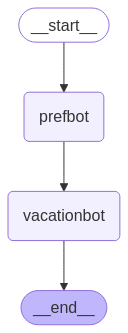

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
### TESTING

state = graph.invoke({ "input":"My last vacation was to the alps, where I went over the Mont Blanc. It was so much fun! I also went shopping but I hated that."})
print(state["output"])


activity_pref='shopping' climate_pref='cold' companions_pref='solo' activity_pair='the user hates to do shopping in cold with no companionship'
Based on your preferences, I'd like to recommend a unique vacation destination that combines shopping and a cold climate.

**Destination:** Reykjavik, Iceland

**Why:**

1. **Shopping:** Reykjavik is known for its vibrant shopping scene, with a variety of boutiques, art galleries, and souvenir shops. You can find everything from traditional Icelandic handicrafts to modern fashion.
2. **Cold Climate:** Iceland is famous for its chilly winters, making it an ideal destination for those who enjoy cold weather. The average temperature in January, the coldest month, is around 32°F (0°C).
3. **Solo Traveler:** Reykjavik is a great city to explore solo, with plenty of museums, galleries, and cultural attractions to keep you engaged. You can also take guided tours or join group activities to meet fellow travelers.

**Additional Recommendations:**

* Vis

In [16]:
### TEST EXAMPLE

# Add config to tell different chats apart
config = {"configurable": {"thread_id": "abc123"}}

query = "Can you recommend me a trip?"
language = "English"

messages = [HumanMessage(content='I like beaches, adventure and sunbathing')]


input_messages = messages + [HumanMessage(query)]
output = app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="values"
)

for op in output:
    op["messages"][-1].pretty_print()  # output contains all messages in state

# query = "What is my name?"
#
# input_messages = [HumanMessage(query)]
# output = app.invoke({"messages": input_messages}, config)
# output["messages"][-1].pretty_print()

NameError: name 'app' is not defined